In [1]:
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sign-language-mnist/sign_mnist_test.csv
/kaggle/input/sign-language-mnist/amer_sign2.png
/kaggle/input/sign-language-mnist/amer_sign3.png
/kaggle/input/sign-language-mnist/sign_mnist_train.csv
/kaggle/input/sign-language-mnist/american_sign_language.PNG
/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv
/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv


import using libraries

In [2]:
import numpy as np 
import pandas as pd 
import torch
import random
import plotly
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import plotly.express as px
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.utils import make_grid
from tqdm import tqdm

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# Загрузка и просмотр датасета

In [3]:
train_data = pd.read_csv("/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv")
test_data = pd.read_csv("/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv")

In [4]:
SL_labels = {}
for l in set(train_data.label):
    SL_labels[l] = list(train_data.label).count(l)
SL_labels

{0: 1126,
 1: 1010,
 2: 1144,
 3: 1196,
 4: 957,
 5: 1204,
 6: 1090,
 7: 1013,
 8: 1162,
 10: 1114,
 11: 1241,
 12: 1055,
 13: 1151,
 14: 1196,
 15: 1088,
 16: 1279,
 17: 1294,
 18: 1199,
 19: 1186,
 20: 1161,
 21: 1082,
 22: 1225,
 23: 1164,
 24: 1118}

## Диаграмма отражающая содержание датасета

In [5]:
px.pie(values=SL_labels.values(), names=SL_labels.keys())

# Подотовка датасетов

In [6]:
class SignDataset(Dataset) :
    def __init__(self, img, label) :
        self.classes = np.array(label)
        img = img / 255.0
        self.img = np.array(img).reshape(-1, 28, 28, 1)
        
        self.transform = T.Compose([
            T.ToTensor()
        ])
        
    def __len__(self) :
        return len(self.img)
    
    def __getitem__(self, index) :
        label = self.classes[index]
        img = self.img[index]
        img = self.transform(img)
        
        label = torch.LongTensor([label])
        img = img.float()
        
        return img, label

In [7]:
train = SignDataset(train_data.drop('label', axis=1), train_data['label'])
test = SignDataset(test_data.drop('label', axis=1), test_data['label'])

In [8]:
def show_image(img, label, dataset):
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')
    plt.title(f"Label: {dataset.classes[label]}\nAlpha Label: {SL_labels[dataset.classes[label]]}")

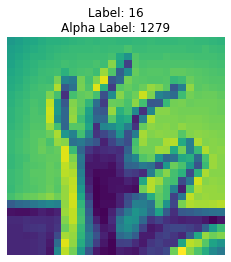

In [9]:
show_image(*train[48], train)

In [10]:
batch_size = 112
train_dl = DataLoader(train, batch_size=batch_size)
test_dl = DataLoader(test, batch_size=batch_size)

In [11]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(20, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

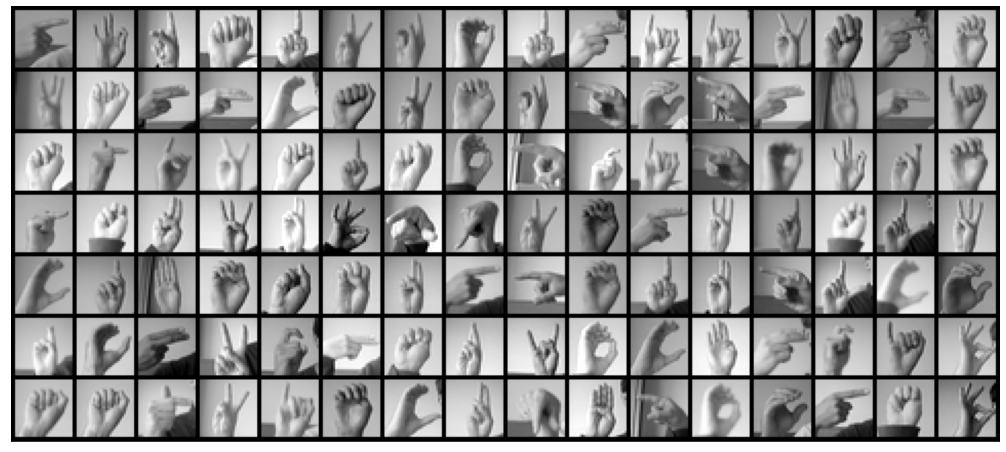

In [12]:
show_batch(test_dl)

# Постройка модели

In [13]:
class ExNet(torch.nn.Module):
    def __init__(self):
        super(ExNet, self).__init__()
        self.Conv1 = nn.Sequential(nn.Conv2d(1, 32, 5),
                                      nn.ReLU(),
                                      nn.BatchNorm2d(32))
        self.Conv2 = nn.Sequential(nn.Conv2d(32, 64, 3), 
                                      nn.BatchNorm2d(64))
        self.Conv3 = nn.Sequential(nn.Conv2d(64, 128, 3),
                                      nn.MaxPool2d(2),
                                      nn.ReLU(),
                                      nn.BatchNorm2d(128))
        self.Conv4 = nn.Sequential(nn.Conv2d(128, 256, 3), 
                                      nn.MaxPool2d(2),
                                      nn.ReLU(),            
                                      nn.BatchNorm2d(256))
        self.Linear1 = nn.Linear(4096, 256)
        self.dropout=nn.Dropout(0.1)
        self.Linear3 = nn.Linear(256, 25)
        
    def forward(self, x):
        x = self.Conv1(x)
        x = self.Conv2(x)
        x = self.Conv3(x)
        x = self.Conv4(x)
        x=self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.Linear1(x)
        x = self.dropout(x)
        x = self.Linear3(x)
        return x  
"""    
a = np.random.rand(28,28)
#print(a)
data = torch.tensor(a).float()
print(data.shape)
# data.unsqueeze_(0).unsqueeze_(0)
data= data.expand(16, 1 ,-1,-1)
print(data.shape)

n=ExNet()
print("Start")
o = n(data)
print(o)
"""
model = ExNet()


# Обучение сети

In [14]:
learning_rate = 0.001
loss_fc = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
num_epochs = 5
losses = []
for epoch in range(num_epochs):
    # for custom progress bar
    with tqdm(train_dl, unit="batch") as tepoch:
        epoch_loss = 0
        epoch_acc = 0
        for data, target in tepoch:
            tepoch.set_description(f"Epoch {epoch + 1}")
            out = model(data)
            loss = loss_fc(out, target.squeeze())
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            tepoch.set_postfix(loss = loss.item()) # show loss and per batch of data
    losses.append(epoch_loss)

Epoch 5: 100%|██████████| 246/246 [02:05<00:00,  1.96batch/s, loss=2.97e-5]


## Вывод результатов

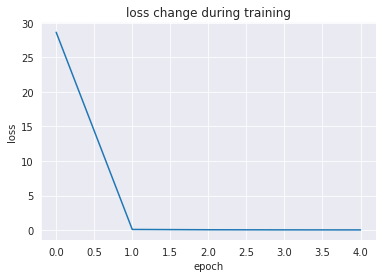

In [16]:
sns.set_style("darkgrid")
sns.lineplot(data=losses).set(title="loss change during training", xlabel="epoch", ylabel="loss")
plt.show()

In [17]:
y_pred = []
y_true = []
with torch.no_grad():
    with tqdm(test_dl, unit="batch") as tepoch:
        for inp, labels in tepoch:
            y_test_pred = model(inp)
            _, y_pred_tag = torch.max(y_test_pred, dim = 1)
            y_pred.append(y_pred_tag.numpy())
            y_true.append(labels.numpy())

100%|██████████| 65/65 [00:12<00:00,  5.24batch/s]


In [18]:
flat_pred = []
flat_true = []
for i in range(len(y_pred)):
    for j in range(len(y_pred[i])):
        flat_pred.append(y_pred[i][j])
        flat_true.append(y_true[i][j])
        
print(f"number of testing samples results: {len(flat_pred)}")

number of testing samples results: 7172


In [19]:
print(f"Testing accuracy is: {accuracy_score(flat_true, flat_pred) * 100:.2f}%")

Testing accuracy is: 95.75%
